In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from pytorch_logit_logic import actfun_name2factory

import matplotlib.pyplot as plt
import numpy as np

# Dataset

In [4]:
# Training settings
batch_size = 64

# MNIST Dataset
train_dataset = datasets.MNIST(root='data/',
                               train=True,
                               transform=transforms.ToTensor(),
                               download=True)

test_dataset = datasets.MNIST(root='data/',
                              train=False,
                              transform=transforms.ToTensor())


In [5]:
# Data Loader (Input Pipeline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False)

# Model

In [30]:
class Net_2(nn.Module):
    def __init__(self, mid_channel_1 = 20, mid_channel_2 = 20, act = 'relu'):
        super(Net_2, self).__init__()

        self.logit_act = actfun_name2factory(act)()
        _actfun = self.logit_act
        divisor = getattr(_actfun, "k", 1)
        feature_factor = getattr(_actfun, "feature_factor", 1)

        self.mid_channel_1 = mid_channel_1
        self.mid_channel_2 = mid_channel_2

        self.conv1 = nn.Conv2d(1, mid_channel_1, kernel_size = 5)
        self.conv2 = nn.Conv2d(int(round(mid_channel_1 * feature_factor)), mid_channel_2, kernel_size=5)
        self.mp = nn.MaxPool2d(2)

        self.fc = nn.Linear(int(round(320 * feature_factor)), 10)

    def forward(self, x):
        in_size = x.size(0)
        x = self.logit_act(self.mp(self.conv1(x)))
        # 64, 5, 12, 12
        x = self.logit_act(self.mp(self.conv2(x)))
        # 64, 20, 4, 4
        x = x.view(in_size, -1)
        # 64, 320
        x = self.fc(x)

        return F.log_softmax(x,dim=1)
    
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.mp = nn.MaxPool2d(2)
        # fully connect
        self.fc = nn.Linear(320, 10)

    def forward(self, x):
        # in_size = 64
        in_size = x.size(0) # one batch
        # x: 64*10*12*12
        x = F.relu(self.mp(self.conv1(x)))
        # x: 64*20*4*4
        x = F.relu(self.mp(self.conv2(x)))
        # x: 64*320
        x = x.view(in_size, -1) # flatten the tensor
        # x: 64*10
        x = self.fc(x)
        return F.log_softmax(x)

def train_a_model(act, epoch = 10):
    print(f'\n training---{act}')
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = Net_2(act = act).to(device)
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)
    test_accuracy_history = []
    test_loss_history = []
    # train
    for epoch in range(0, epoch):
        
        for batch_idx, (data, target) in enumerate(train_loader):
            
            data, target = Variable(data).to(device), Variable(target).to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = F.cross_entropy(output, target)
            loss.backward()
            optimizer.step()
            if batch_idx % 1000 == 0:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    epoch, batch_idx * len(data), len(train_loader.dataset),
                    100. * batch_idx / len(train_loader), loss.item()))
                
        test_loss = 0
        correct = 0
        for data, target in test_loader:
            with torch.no_grad():
                data, target = Variable(data).to(device), Variable(target).to(device)
                output = model(data)
                # sum up batch loss
                test_loss += F.cross_entropy(output, target, reduction='sum').item()
                # get the index of the max log-probability
                pred = output.data.max(1, keepdim=True)[1]
                #print(pred)
                correct += pred.eq(target.data.view_as(pred)).cpu().sum()


        test_loss /= len(test_loader.dataset)
        test_accuracy_history.append(100. * correct.item() / len(test_loader.dataset))
        test_loss_history.append(test_loss)
        print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)'.format(
            test_loss, correct, len(test_loader.dataset),
            100. * correct / len(test_loader.dataset)))
    
    return model, test_accuracy_history,test_loss_history


In [47]:
def get_parameter_number(net):
    total_num = sum(p.numel() for p in net.parameters())
    trainable_num = sum(p.numel() for p in net.parameters() if p.requires_grad)
    return {'Total': total_num, 'Trainable': trainable_num}
get_parameter_number(model_ail_xnor)

{'Total': 7150, 'Trainable': 7150}

# Training

In [37]:
model_ail_or, accuracy_history_ail_or, test_loss_history_ail_or = train_a_model('ail_or', epoch = 10)
model_relu, accuracy_history_relu, test_loss_history_relu = train_a_model('relu', epoch = 10)
model_max, accuracy_history_max, test_loss_history_max = train_a_model('max', epoch = 10)
model_nail_or, accuracy_history_nail_or, test_loss_history_nail_or = train_a_model('nail_or', epoch = 10)
model_ail_xnor, accuracy_history_ail_xnor, test_loss_history_ail_xnor = train_a_model('ail_xnor', epoch = 10)
model_ail_or_xnor_dup, accuracy_history_ail_or_xnor_dup, test_loss_history_ail_or_xnor_dup = train_a_model('ail_or_xnor_dup', epoch = 10)

training---ail_or
Train Epoch: 0 [0/60000 (0%)]	Loss: 2.349748
Test set: Average loss: 0.1588, Accuracy: 9535/10000 (95%)
Train Epoch: 1 [0/60000 (0%)]	Loss: 0.172657
Test set: Average loss: 0.1045, Accuracy: 9674/10000 (97%)
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.154340
Test set: Average loss: 0.0822, Accuracy: 9744/10000 (97%)
Train Epoch: 3 [0/60000 (0%)]	Loss: 0.036821
Test set: Average loss: 0.0821, Accuracy: 9741/10000 (97%)
Train Epoch: 4 [0/60000 (0%)]	Loss: 0.071494
Test set: Average loss: 0.0655, Accuracy: 9789/10000 (98%)
Train Epoch: 5 [0/60000 (0%)]	Loss: 0.059222
Test set: Average loss: 0.0604, Accuracy: 9797/10000 (98%)
Train Epoch: 6 [0/60000 (0%)]	Loss: 0.091174
Test set: Average loss: 0.0549, Accuracy: 9818/10000 (98%)
Train Epoch: 7 [0/60000 (0%)]	Loss: 0.024369
Test set: Average loss: 0.0601, Accuracy: 9795/10000 (98%)
Train Epoch: 8 [0/60000 (0%)]	Loss: 0.058148
Test set: Average loss: 0.0512, Accuracy: 9837/10000 (98%)
Train Epoch: 9 [0/60000 (0%)]	Loss: 0.094871
T

# Plot

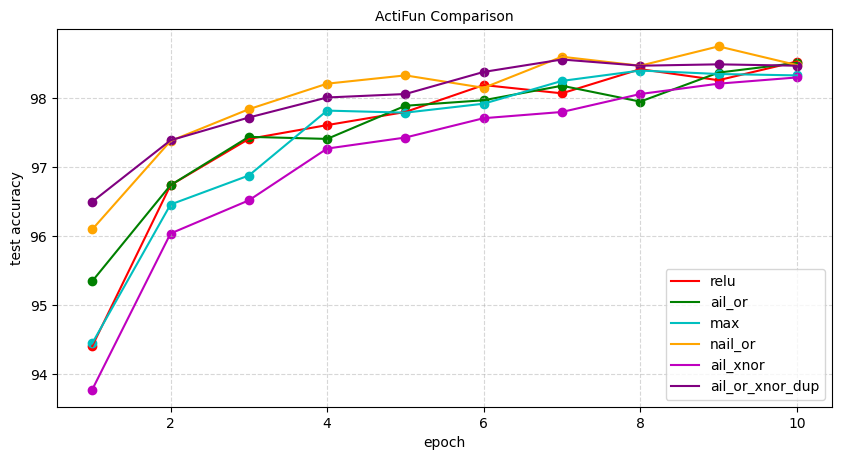

In [40]:
plt.figure(figsize=(10, 5), dpi=100)
game = np.arange(1,11)
plt.plot(game, accuracy_history_relu, c='red', label="relu")
plt.plot(game, accuracy_history_ail_or, c='green', label="ail_or")
plt.plot(game, accuracy_history_max, c='c', label="max")
plt.plot(game, accuracy_history_nail_or, c='orange', label="nail_or")
plt.plot(game, accuracy_history_ail_xnor, c='m', label="ail_xnor")
plt.plot(game, accuracy_history_ail_or_xnor_dup, c='purple', label="ail_or_xnor_dup")


plt.scatter(game, accuracy_history_relu, c='red')
plt.scatter(game, accuracy_history_ail_or, c='green')
plt.scatter(game, accuracy_history_max, c='c')
plt.scatter(game, accuracy_history_nail_or, c='orange')
plt.scatter(game, accuracy_history_ail_xnor, c='m')
plt.scatter(game, accuracy_history_ail_or_xnor_dup, c='purple')


plt.legend(loc='best')
#plt.yticks(range(0, 50, 5))
plt.grid(True, linestyle='--', alpha=0.5)
plt.xlabel("epoch", fontdict={'size': 10})
plt.ylabel("test accuracy", fontdict={'size': 10})
plt.title("ActiFun Comparison", fontdict={'size': 10})
plt.show()

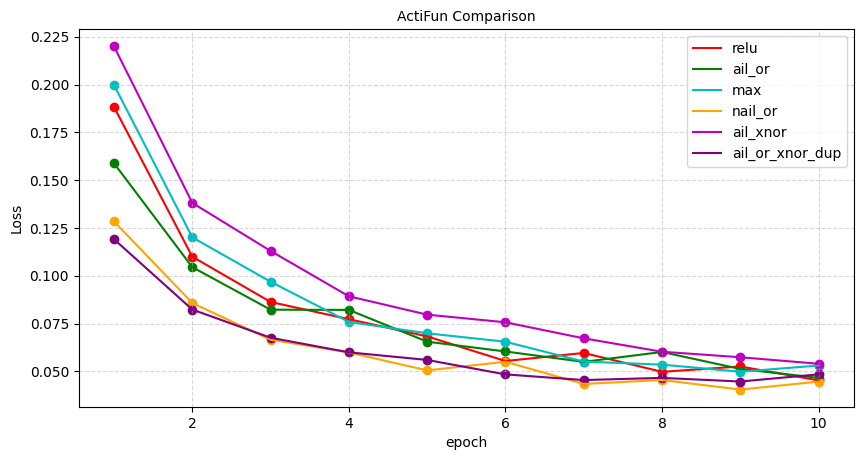

In [42]:
plt.figure(figsize=(10, 5), dpi=100)
game = np.arange(1,11)
plt.plot(game, test_loss_history_relu, c='red', label="relu")
plt.plot(game, test_loss_history_ail_or, c='green', label="ail_or")
plt.plot(game, test_loss_history_max, c='c', label="max")
plt.plot(game, test_loss_history_nail_or, c='orange', label="nail_or")
plt.plot(game, test_loss_history_ail_xnor, c='m', label="ail_xnor")
plt.plot(game, test_loss_history_ail_or_xnor_dup, c='purple', label="ail_or_xnor_dup")


plt.scatter(game, test_loss_history_relu, c='red')
plt.scatter(game, test_loss_history_ail_or, c='green')
plt.scatter(game, test_loss_history_max, c='c')
plt.scatter(game, test_loss_history_nail_or, c='orange')
plt.scatter(game, test_loss_history_ail_xnor, c='m')
plt.scatter(game, test_loss_history_ail_or_xnor_dup, c='purple')


plt.legend(loc='best')
#plt.yticks(range(0, 50, 5))
plt.grid(True, linestyle='--', alpha=0.5)
plt.xlabel("epoch", fontdict={'size': 10})
plt.ylabel("Loss", fontdict={'size': 10})
plt.title("ActiFun Comparison", fontdict={'size': 10})
plt.show()

# Save file

In [43]:
# import pickle

# def save_file(list_name,list_data):
#     with open(list_name+'.pickle', 'wb') as f:
#         pickle.dump(list_data, f)
# save_file('accuracy_history_relu',accuracy_history_relu)
# save_file('accuracy_history_ail_or',accuracy_history_ail_or)
# save_file('accuracy_history_max',accuracy_history_max)
# save_file('accuracy_history_nail_or',accuracy_history_nail_or)
# save_file('accuracy_history_ail_xnor',accuracy_history_ail_xnor)
# save_file('accuracy_history_ail_or_xnor_dup',accuracy_history_ail_or_xnor_dup)

# save_file('test_loss_history_relu',test_loss_history_relu)
# save_file('test_loss_history_ail_or',test_loss_history_ail_or)
# save_file('test_loss_history_max',test_loss_history_max)
# save_file('test_loss_history_nail_or',test_loss_history_nail_or)
# save_file('test_loss_history_ail_xnor',test_loss_history_ail_xnor)
# save_file('test_loss_history_ail_or_xnor_dup',test_loss_history_ail_or_xnor_dup)


In [156]:
def get_parameter_number(model):
    total_num = sum(p.numel() for p in model.parameters())
    trainable_num = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return {'Total': total_num, 'Trainable': trainable_num}


{'Total': 7150, 'Trainable': 7150}

In [158]:
get_parameter_number(model_relu)

{'Total': 13750, 'Trainable': 13750}